In [6]:
# First example: Bank renege
import simpy 
import random
# generate customers 
def source(env,number,interval,counter):
    # generate number customers
    for i in range(number):
        c = customer(env,"C%d" % i,counter,time_in_bank=12.0)
        env.process(c)
        t = random.expovariate(1.0/interval)
        yield env.timeout(t)
# customer
def customer(env,name,counter,time_in_bank):
    arrive = env.now
    print('%s arrives at %4.5f' % (name, env.now))
    with counter.request() as req:
        patience = random.uniform(1,4)
        results  = yield req | env.timeout(patience)
        wait = env.now - arrive
        if req in results:
            print ("%s waited for %4.5f" % (name,wait))
            time_in = random.expovariate(1.0/time_in_bank)
            yield env.timeout(time_in)
            print ("%s finished at %4.5f" % (name,env.now))
        else:
            print ("%s FUCK the bank at %4.5f" % (name,env.now))
            
env = simpy.Environment()
counter = simpy.Resource(env,capacity=1)
env.process(source(env,3,10.0,counter))
env.run()

C0 arrives at 0.00000
C0 waited for 0.00000
C1 arrives at 3.58450
C1 FUCK the bank at 7.47729
C2 arrives at 11.80157
C2 FUCK the bank at 13.30895
C0 finished at 16.79912


In [56]:
"""
Movie renege example

Covers:

- Resources: Resource
- Condition events
- Shared events

Scenario:
  A movie theatre has one ticket counter selling tickets for three
  movies (next show only). When a movie is sold out, all people waiting
  to buy tickets for that movie renege (leave queue).

"""
import collections
import random

import simpy


RANDOM_SEED = 42
TICKETS = 50  # Number of tickets per movie
SIM_TIME = 120  # Simulate until


def moviegoer(env, movie, num_tickets, theater):
    """A moviegoer tries to by a number of tickets (*num_tickets*) for
    a certain *movie* in a *theater*.

    If the movie becomes sold out, she leaves the theater. If she gets
    to the counter, she tries to buy a number of tickets. If not enough
    tickets are left, she argues with the teller and leaves.

    If at most one ticket is left after the moviegoer bought her
    tickets, the *sold out* event for this movie is triggered causing
    all remaining moviegoers to leave.

    """
    with theater.counter.request() as my_turn:
        # Wait until its our turn or until the movie is sold out
        result = yield my_turn | theater.sold_out[movie]

        # Check if it's our turn of if movie is sold out
        if my_turn not in result:
            theater.num_renegers[movie] += 1
            env.exit()

        # Check if enough tickets left.
        if theater.available[movie] < num_tickets:
            # Moviegoer leaves after some discussion
            yield env.timeout(0.5)
            env.exit()

        # Buy tickets
        theater.available[movie] -= num_tickets
        if theater.available[movie] < 2:
            # Trigger the "sold out" event for the movie
            theater.sold_out[movie].succeed()
            theater.when_sold_out[movie] = env.now
            theater.available[movie] = 0
        yield env.timeout(1)


def customer_arrivals(env, theater):
    """Create new *moviegoers* until the sim time reaches 120."""
    while True:
        yield env.timeout(random.expovariate(1 / 0.5))

        movie = random.choice(theater.movies)
        num_tickets = random.randint(1, 6)
        if theater.available[movie]:
            env.process(moviegoer(env, movie, num_tickets, theater))


Theater = collections.namedtuple('Theater', 'counter, movies, available, '
                                            'sold_out, when_sold_out, '
                                            'num_renegers')


# Setup and start the simulation
print('Movie renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Create movie theater
counter = simpy.Resource(env, capacity=1)
movies = ['Python Unchained', 'Kill Process', 'Pulp Implementation']
available = {movie: TICKETS for movie in movies}
sold_out = {movie: env.event() for movie in movies}
when_sold_out = {movie: None for movie in movies}
num_renegers = {movie: 0 for movie in movies}
theater = Theater(counter, movies, available, sold_out, when_sold_out,
                  num_renegers)

# Start process and run
env.process(customer_arrivals(env, theater))
env.run(until=SIM_TIME)

# Analysis/results
for movie in movies:
    if theater.sold_out[movie]:
        print('Movie "%s" sold out %.1f minutes after ticket counter '
              'opening.' % (movie, theater.when_sold_out[movie]))
        print('  Number of people leaving queue when film sold out: %s' %
              theater.num_renegers[movie])


Movie renege
Movie "Python Unchained" sold out 26.5 minutes after ticket counter opening.
  Number of people leaving queue when film sold out: 7
Movie "Kill Process" sold out 39.0 minutes after ticket counter opening.
  Number of people leaving queue when film sold out: 5
Movie "Pulp Implementation" sold out 41.0 minutes after ticket counter opening.
  Number of people leaving queue when film sold out: 1


In [71]:
from collections import namedtuple
t = namedtuple('t','a,b')
x = 2
y = 3
z = t(x,y)
len(z)

2

In [6]:
# carwash
import simpy
import random

class Carwash(object):
    def __init__(self,env,num_machines,washtime):
        self.env = env
        self.machine = simpy.Resource(env,num_machines)
        self.washtime = washtime
    def wash(self,car):
        yield self.env.timeout(5)
        print('Carwash removed %d of %s\'s dirt' % (random.randint(50,99),car) )
def car(env,name,cw):
    print("%s arrives at %.2f" % (name,env.now))
    with cw.machine.request() as req:
        yield req
        print('%s enters the carwash at %.2f' % (name,env.now))
        yield env.process(cw.wash(name))
        print('%s leaves the carwash at %.2f' % (name,env.now))
def setup(env,num_machines,washtime,t_inter):
    carwash = Carwash(env,num_machines,washtime)
    for i in range(4):
        env.process(car(env,'Car %d' % i,carwash))
    while True:
        yield env.timeout(random.randint(t_inter-2,t_inter+2))
        i += 1
        env.process(car(env,'Car %d' % i, carwash))
        
env = simpy.Environment()
env.process(setup(env,2,5,7))
env.run(30)

Car 0 arrives at 0.00
Car 1 arrives at 0.00
Car 2 arrives at 0.00
Car 3 arrives at 0.00
Car 0 enters the carwash at 0.00
Car 1 enters the carwash at 0.00
Car 4 arrives at 5.00
Carwash removed 67 of Car 0's dirt
Carwash removed 84 of Car 1's dirt
Car 0 leaves the carwash at 5.00
Car 1 leaves the carwash at 5.00
Car 2 enters the carwash at 5.00
Car 3 enters the carwash at 5.00
Carwash removed 68 of Car 2's dirt
Carwash removed 50 of Car 3's dirt
Car 2 leaves the carwash at 10.00
Car 3 leaves the carwash at 10.00
Car 4 enters the carwash at 10.00
Car 5 arrives at 12.00
Car 5 enters the carwash at 12.00
Carwash removed 72 of Car 4's dirt
Car 4 leaves the carwash at 15.00
Carwash removed 77 of Car 5's dirt
Car 5 leaves the carwash at 17.00
Car 6 arrives at 20.00
Car 6 enters the carwash at 20.00
Carwash removed 84 of Car 6's dirt
Car 6 leaves the carwash at 25.00
Car 7 arrives at 28.00
Car 7 enters the carwash at 28.00


In [14]:
# Gas Station
import simpy
import random
import itertools

RANDOM_SEED = 42
GAS_STATION_SIZE = 200     # liters
THRESHOLD = 10             # Threshold for calling the tank truck (in %)
FUEL_TANK_SIZE = 50        # liters
FUEL_TANK_LEVEL = [5, 25]  # Min/max levels of fuel tanks (in liters)
REFUELING_SPEED = 2        # liters / second
TANK_TRUCK_TIME = 300      # Seconds it takes the tank truck to arrive
T_INTER = [30, 300]        # Create a car every [min, max] seconds
SIM_TIME = 1000            # Simulation time in seconds

def car(name,env,gas_station,fuel_pump):
    fuel_tank_level = random.randint(*FUEL_TANK_LEVEL)
    print('%s arrives at %.2f' % (name,env.now))
    with gas_station.request() as req:
        start = env.now
        yield req
        liters_required = FUEL_TANK_SIZE - fuel_tank_level
        yield fuel_pump.get(liters_required)
        yield env.timeout(liters_required/REFUELING_SPEED)
        print('%s finished refueling in %.1f seconds.' % (name,env.now-start))
        
        
def gas_station_control(env,fuel_pump):
    while True:
        if fuel_pump.level / fuel_pump.capacity *100 < THRESHOLD:
            print('Calling tank truck at %d' % env.now)
            yield env.process(tank_truck(env,fuel_pump))
        yield env.timeout(1)
def tank_truck(env,fuel_pump):
    yield env.timeout(TANK_TRUCK_TIME)
    print('Tank truck arriving at time %.2f' % env.now)
    ammount = fuel_pump.capacity - fuel_pump.level
    print('Tank truck refuelling %.1f liters.' % ammount)
    yield fuel_pump.put(ammount)
    
def car_generation(env,gas_station,fuel_pump):
    for i in itertools.count():
        yield env.process(car('Car %d' % i,env,gas_station,fuel_pump))
  
env = simpy.Environment()
gas_station = simpy.Resource(env,2)
fuel_pump = simpy.Container(env,GAS_STATION_SIZE,init=GAS_STATION_SIZE)
env.process(gas_station_control(env,fuel_pump))
env.process(car_generation(env,gas_station,fuel_pump))
env.run(SIM_TIME)

Car 0 arrives at 0.00
Calling tank truck at 1
Car 0 finished refueling in 21.0 seconds.
Car 1 arrives at 21.00
Car 1 finished refueling in 15.0 seconds.
Car 2 arrives at 36.00
Car 2 finished refueling in 21.0 seconds.
Car 3 arrives at 57.00
Car 3 finished refueling in 21.0 seconds.
Car 4 arrives at 78.00
Car 4 finished refueling in 21.0 seconds.
Car 5 arrives at 99.00
Tank truck arriving at time 301.00
Tank truck refuelling 199.0 liters.
Calling tank truck at 302
Car 5 finished refueling in 222.0 seconds.
Car 6 arrives at 321.00
Car 6 finished refueling in 16.0 seconds.
Car 7 arrives at 337.00
Car 7 finished refueling in 14.0 seconds.
Car 8 arrives at 351.00
Car 8 finished refueling in 20.0 seconds.
Car 9 arrives at 371.00
Car 9 finished refueling in 16.0 seconds.
Car 10 arrives at 387.00
Tank truck arriving at time 602.00
Tank truck refuelling 177.0 liters.
Calling tank truck at 603
Car 10 finished refueling in 227.0 seconds.
Car 11 arrives at 614.00
Car 11 finished refueling in 21.0 

In [1]:
import simpy
class Cable(object):
    def __init__(self,env,store):
        self.env = env
        self.store = store
#     def late(self,msg):
#         yield self.env.timeout(10)
#         self.store.put(msg)
    def put(self,msg):
#         env.process(self.late(msg))
        yield env.timeout(10)
        self.store.put(msg)
    def get(self):
        return self.store.get()
        
def sender(env,cable):
    while True:
        yield env.timeout(5)
        cable.put('Sending at %.2f' % env.now)
#         env.process(cable.put('Sending at %.2f' % env.now))

def receiver(env,cable):
    while True:
        msg = yield cable.get()
        print('Reveing at %.2f : %s' % (env.now, msg))
              
env = simpy.Environment()
store = simpy.Store(env)
cable = Cable(env,store)

env.process(sender(env,cable))
env.process(receiver(env,cable))
env.run(until=100)

In [31]:
l = [2]
if not l:
    print ("it is empty")

In [2]:
import simpy
import random
# def message_generator(name,env,out_pip):
#     # 随机产生消息的进程
#     while True:
#         yield env.timeout(random.randint(6,10))
#         msg = (env.now,'%s says hello at %.2f' % (name,env.now))
#         out_pip.put(msg)
# def message_consumer(name,env,in_pip):
#     while True:
#         msg = yield in_pip.get()
#         if msg[0]<env.now:
#             print('Late %s receiving message at %.2f' % (name,env.now))
#         else:
#             print('at time %.2f: %s reveiving message' % (env.now,name))
#         yield env.timeout(random.randint(4,8))
  
def message_generator(name, env, out_pipe):
    """A process which randomly generates messages."""
    while True:
        # wait for next transmission
        yield env.timeout(random.randint(6, 10))

        # messages are time stamped to later check if the consumer was
        # late getting them.  Note, using event.triggered to do this may
        # result in failure due to FIFO nature of simulation yields.
        # (i.e. if at the same env.now, message_generator puts a message
        # in the pipe first and then message_consumer gets from pipe,
        # the event.triggered will be True in the other order it will be
        # False
        msg = (env.now, '%s says hello at %d' % (name, env.now))
        out_pipe.put(msg)


def message_consumer(name, env, in_pipe):
    """A process which consumes messages."""
    while True:
        # Get event for message pipe
        msg = yield in_pipe.get()

        if msg[0] < env.now:
            # if message was already put into pipe, then
            # message_consumer was late getting to it. Depending on what
            # is being modeled this, may, or may not have some
            # significance
            print('LATE Getting Message: at time %d: %s received message: %s' %
                  (env.now, name, msg[1]))

        else:
            # message_consumer is synchronized with message_generator
            print('at time %d: %s received message: %s.' %
                  (env.now, name, msg[1]))

        # Process does some other work, which may result in missing messages
        yield env.timeout(random.randint(4, 10))

    
    
print('Process communication')
random.seed(14)
env = simpy.Environment()
pip = simpy.Store(env)
env.process(message_generator('Generator A',env,pip))
env.process(message_consumer('Consumer B',env,pip))
env.run(300)

Process communication
at time 6: Consumer B received message: Generator A says hello at 6.
at time 15: Consumer B received message: Generator A says hello at 15.
at time 25: Consumer B received message: Generator A says hello at 25.
LATE Getting Message: at time 34: Consumer B received message: Generator A says hello at 32
at time 41: Consumer B received message: Generator A says hello at 41.
at time 50: Consumer B received message: Generator A says hello at 50.
at time 59: Consumer B received message: Generator A says hello at 59.
LATE Getting Message: at time 69: Consumer B received message: Generator A says hello at 66
LATE Getting Message: at time 74: Consumer B received message: Generator A says hello at 73
at time 83: Consumer B received message: Generator A says hello at 83.
LATE Getting Message: at time 90: Consumer B received message: Generator A says hello at 89
at time 98: Consumer B received message: Generator A says hello at 98.
at time 107: Consumer B received message: Ge

In [55]:
import simpy,random
def car(env):
    while True:
        print('Start driving at %2.f' % env.now)
        driving_time = random.randint(1,10)
        yield env.timeout(driving_time)
#         print("Driving for %.2f" % driving_time)
        parking_time = random.randint(2,20)
        print('Start packing at %.2f' % env.now)
        yield env.timeout(parking_time)
        print('Parking for %.2f' % parking_time)
env = simpy.Environment()
env.process(car(env))
env.run(100)

Start driving at  0
Start packing at 4.00
Parking for 9.00
Start driving at 13
Start packing at 23.00
Parking for 12.00
Start driving at 35
Start packing at 43.00
Parking for 7.00
Start driving at 50
Start packing at 60.00
Parking for 13.00
Start driving at 73
Start packing at 76.00
Parking for 19.00
Start driving at 95


In [75]:
import simpy
import random
class Car:
    def __init__(self,name,env):
        self.env = env
        self.name = name
        self.proc = env.process(self.run())
    def run(self):
        while True:
            print ('%s Charging at %d' % (self.name,env.now))
            chargetime = random.randint(2,19)
            try:
                yield self.env.process(self.charge(chargetime))
            except simpy.Interrupt:
                print("Charging process was interrupted!")
            print('%s starts driving at %d' % (self.name,env.now))
            yield self.env.timeout(10)
    def charge(self,duration):
        yield self.env.timeout(duration)
        
def driver(env,car):
    yield env.timeout(1)
#     print('Driver needs a nap')
    car.proc.interrupt()
env = simpy.Environment()
car = Car('A',env)
env.process(driver(env,car))
env.run(100)

A Charging at 0
Charging process was interrupted!
A starts driving at 1
A Charging at 11
A starts driving at 28
A Charging at 38
A starts driving at 47
A Charging at 57
A starts driving at 75
A Charging at 85
A starts driving at 88
A Charging at 98


In [105]:
import math
class Point(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    @property
    def distance(self):
        return math.sqrt(self.x**2 + self.y**2)
#     def __repr__(self):
#         return "2"
p = Point(3,4)
p

2

In [102]:
# use simpy to simulate M/M/1
import simpy
import random
class Chef(object):
    def __init__(self,env,line,mu=1.0/10):
        self.env = env
        self.mu  = mu
        self.line = line
        self.env.process(self.run())
    def run(self):
        while True:
            print('Chef: Waiting for the next one')
            yield self.line.next_one()
            print('Chef: Servering now at %.2f' % self.env.now)
            service_time = random.expovariate(self.mu)
            yield self.env.timeout(service_time)
            print('Chef: End serverice at %.2f' % self.env.now)
            
class Line(object):
    def __init__(self,env,capacity=None):
        self.env = env
        if capacity is None:
            self.queue = simpy.Container(env,init=0)
        else:
            self.queue = simpy.Container(env,capacity,init=0)
    def let_in(self):
        return self.queue.put(1)
    def next_one(self):
        return self.queue.get(1)
    @property
    def level(self):
        return self.queue.level
class Door(object):
    def __init__(self,env,line,lamb=1.0/2):
        self.env = env
        self.line = line
        self.lamb = lamb
        self.env.process(self.run())
    def run(self):
        while True:
            arrival_time = random.expovariate(self.lamb)
            yield self.env.timeout(arrival_time)
            print('Door: put one')
            yield self.line.let_in()
            
def show(env,line):
    while True:
        now = line.level
        print ("%d people now are queuing" % now)
        yield env.timeout(1)
            
env = simpy.Environment()
line = Line(env,10)
chef = Chef(env,line)
door = Door(env,line)
env.process(show(env,line))
env.run(30)

Chef: Waiting for the next one
0 people now are queuing
0 people now are queuing
Door: put one
Chef: Servering now at 1.40
0 people now are queuing
0 people now are queuing
0 people now are queuing
0 people now are queuing
Chef: End serverice at 5.07
Chef: Waiting for the next one
0 people now are queuing
Door: put one
Chef: Servering now at 6.23
Door: put one
Door: put one
2 people now are queuing
2 people now are queuing
2 people now are queuing
2 people now are queuing
2 people now are queuing
2 people now are queuing
2 people now are queuing
Door: put one
3 people now are queuing
Door: put one
4 people now are queuing
Door: put one
5 people now are queuing
Door: put one
Chef: End serverice at 16.43
Chef: Waiting for the next one
Chef: Servering now at 16.43
5 people now are queuing
Door: put one
6 people now are queuing
6 people now are queuing
6 people now are queuing
Door: put one
Door: put one
8 people now are queuing
Door: put one
Door: put one
10 people now are queuing
10 peop

['AllOf',
 'AnyOf',
 'Container',
 'Environment',
 'Event',
 'FilterStore',
 'Interrupt',
 'PreemptiveResource',
 'PriorityResource',
 'Process',
 'RealtimeEnvironment',
 'Resource',
 'Store',
 'Timeout',
 '__all__',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__path__',
 '__version__',
 '_compat',
 'compile_toc',
 'core',
 'events',
 'extend_path',
 'obj',
 'objs',
 'resources',
 'rt',
 'section',
 'test',
 'toc',
 'util']

In [108]:
import random
random.random()

0.2367018077656785

In [121]:
# learning SimComponents
from random import expovariate
import simpy
from SimComponents import PacketGenerator, PacketSink

def arrival():
    return 1.2
def size():
    return expovariate(1.0)

env = simpy.Environment()
ps = PacketSink(env,debug=True)
pg = PacketGenerator(env,'ALL or NOTHING',arrival,size)
pg.out = ps
env.run(until=30)

id: 1, src: ALL or NOTHING, time: 1.2, size: 1.294561819
id: 2, src: ALL or NOTHING, time: 2.4, size: 2.37499725196
id: 3, src: ALL or NOTHING, time: 3.6, size: 0.751393438262
id: 4, src: ALL or NOTHING, time: 4.8, size: 0.529510982898
id: 5, src: ALL or NOTHING, time: 6.0, size: 0.626328470461
id: 6, src: ALL or NOTHING, time: 7.2, size: 1.69865968916
id: 7, src: ALL or NOTHING, time: 8.4, size: 0.480155274537
id: 8, src: ALL or NOTHING, time: 9.6, size: 0.141836502151
id: 9, src: ALL or NOTHING, time: 10.8, size: 0.0675497111579
id: 10, src: ALL or NOTHING, time: 12.0, size: 1.0376076287
id: 11, src: ALL or NOTHING, time: 13.2, size: 0.120498696315
id: 12, src: ALL or NOTHING, time: 14.4, size: 0.727289112483
id: 13, src: ALL or NOTHING, time: 15.6, size: 2.90052426127
id: 14, src: ALL or NOTHING, time: 16.8, size: 0.867099875472
id: 15, src: ALL or NOTHING, time: 18.0, size: 0.832560241511
id: 16, src: ALL or NOTHING, time: 19.2, size: 2.26432122783
id: 17, src: ALL or NOTHING, time

In [118]:
import SimComponents as sc
dir(sc)

['BoundClass',
 'FlowDemux',
 'Packet',
 'PacketGenerator',
 'PacketSink',
 'PortMonitor',
 'RandomBrancher',
 'ShaperTokenBucket',
 'SnoopSplitter',
 'StampedStore',
 'StampedStoreGet',
 'StampedStorePut',
 'SwitchPort',
 'VirtualClockServer',
 'WFQServer',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'base',
 'copy',
 'heappop',
 'heappush',
 'random',
 'simpy']

In [129]:
import simpy,random
from SimComponents import PacketGenerator,PacketSink,SwitchPort

def arrival():
    return 1.5 #每隔1.5秒
def size():
    return 100 # 100个字节
env = simpy.Environment()
ps = PacketSink(env,debug=True)
pg = PacketGenerator(env,'SIST',arrival,size)
sp = SwitchPort(env,200,300,)
pg.out = sp
sp.out = ps
env.run(20)
print('received:{}, dropped:{}, total_sent:{}'.format(ps.packets_rec,sp.packets_drop,pg.packets_sent))

id: 1, src: SIST, time: 1.5, size: 100
id: 1, src: SIST, time: 1.5, size: 100
id: 2, src: SIST, time: 3.0, size: 100
id: 2, src: SIST, time: 3.0, size: 100
id: 3, src: SIST, time: 4.5, size: 100
id: 3, src: SIST, time: 4.5, size: 100
id: 4, src: SIST, time: 6.0, size: 100
id: 4, src: SIST, time: 6.0, size: 100
received:4, dropped:6, total_sent:13


Last 10 wait time: 79.68,80.38,79.94,79.98,78.89,78.96,78.95,79.30,79.50,79.51
Last 10 queue sizes: [185, 184, 186, 187, 188, 190, 186, 186, 187, 185]
Last 10 arrival: 0.36,1.11,0.41,0.24,0.28,0.12,0.48,0.66,0.34,0.04
average wait: 77.067
Received:2245, Dropped:1593, Total sent: 4023
loss rate:39.60%
average system occupancy:180.0


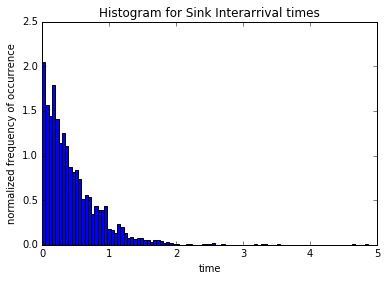

'simpy'

In [25]:
# use SimComponents.py to simulate M/M/1
%matplotlib inline
import simpy, random
from SimComponents import PacketSink, PacketGenerator, SwitchPort, PortMonitor
import matplotlib.pyplot as plt

def arrival():
    return random.expovariate(4)
def size():
    return random.expovariate(0.01)
def check():
    return random.expovariate(1.0)

env = simpy.Environment()

packet_creator = PacketGenerator(env,'Jerry',arrival,size)
packet_sink    = PacketSink(env,rec_arrivals=True,absolute_arrivals=False) 
switch_port    = SwitchPort(env,1000,qlimit=10000)
port_monitor   = PortMonitor(env,switch_port,check)
packet_creator.out = switch_port
switch_port.out = packet_sink
env.run(1000)
print('Last 10 wait time: ' + ','.join("{:.2f}".format(x) for x in packet_sink.waits[-10:]))
print('Last 10 queue sizes: {}'.format(port_monitor.sizes[-10:]))
print("Last 10 arrival: " + ','.join("{:.2f}".format(x) for x in packet_sink.arrivals[-10:]))
print('average wait: {:.3f}'.format(sum(packet_sink.waits)/len(packet_sink.waits)))
print('Received:{}, Dropped:{}, Total sent: {}'.format(packet_sink.packets_rec, switch_port.packets_drop,packet_creator.packets_sent))
print('loss rate:{:.2f}%'.format(switch_port.packets_drop*100.0/switch_port.packets_rec))
print('average system occupancy:{}'.format(float(sum(port_monitor.sizes)/len(port_monitor.sizes))))

fig,axis = plt.subplots()
axis.hist(packet_sink.arrivals, bins=100, normed=True)
axis.set_title("Histogram for Sink Interarrival times")
axis.set_xlabel("time")
axis.set_ylabel("normalized frequency of occurrence")
    # fig.savefig("ArrivalHistogram.png")
plt.show()


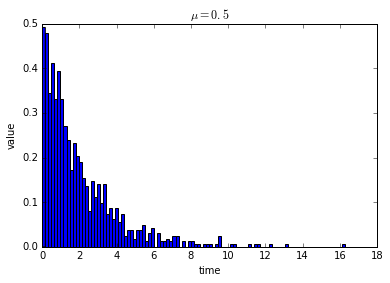

In [24]:
%matplotlib inline
from random import expovariate
import matplotlib.pyplot as plt
time = expovariate(0.5)
t = [expovariate(0.5) for i in range(1000)]
fig,axis = plt.subplots()
axis.hist(t,bins=100,normed=True)
axis.set_xlabel("time")
axis.set_ylabel("value")
axis.set_title(r"$\mu = 0.5$")
plt.show()

In [17]:
import simpy
class Flow(object):   
    # def __init__(self,src,des,demand,size):
    # src and des are integer
    def __init__(self,time,src,des,size):
        self.begin_time = time
        self.src = src
        self.end_time = time
        self.des = des
#        self.demand = demand # bandwidth demand of each flow
        self.size = size # flow size such as 1Gb
    def __repr__(self):
        return "from {} to {},\t size: {:.4f},\t time: {:.2f}".format(self.src,self.des,self.size,self.begin_time)
        
env = simpy.Environment()
store = simpy.Store(env)
flows = []
# for i in range(10):
#     store.put(Flow(12,1,2,123))
# for it in store.items:
#     print it.begin_time,
print store.items is None


False


In [55]:
import simpy

class Message(object):
    def __init__(self,env,id,time):
        self.env = env
        self.id = id
        self.time = env.now
    def __repr__(self):
        return "id:{},time:{}".format(self.id,self.time)
def msg_generator(env,out):
    i = 0
    while True:
        yield env.timeout(3)
        msg = Message(env,i,env.now)
        i += 1
        out.put(msg)
def get_msg(env,store):
    while True:
        yield env.timeout(2)
        print (store.items)
        msg = yield store.get()
        print (store.items)
        print "get msg at %d: " % env.now,
        print msg
    
class MyStore(object):
    def __init__(self,env,qlimit=None):
        self.qlimit = qlimit
        self.env = env
        self.store = simpy.Store(env)
        self.rec_msg = 0
        self.drop_msg = 0
        self.env.process(self.run())
    def run(self):
        while True:
            #print len(self.store.items)
            msg = yield self.store.get()
            #print len(self.store.items)
            print "%.2f receive: " % self.env.now,
            print msg
    def put(self,msg):
        temp = self.rec_msg+1
        if not self.qlimit:
            self.rec_msg += 1
            self.store.put(msg)
        else:
            if temp>self.qlimit:
                self.drop_msg += 1
            else:
                self.rec_msg += 1
                self.store.put(msg)
env = simpy.Environment()
my = MyStore(env,qlimit=10)
store = simpy.Store(env)
env.process(msg_generator(env,store))
env.process(get_msg(env,store))
env.run(100)


[]
[]
get msg at 3:  id:0,time:3
[]
[]
get msg at 6:  id:1,time:6
[]
[]
get msg at 9:  id:2,time:9
[]
[]
get msg at 12:  id:3,time:12
[]
[]
get msg at 15:  id:4,time:15
[]
[]
get msg at 18:  id:5,time:18
[]
[]
get msg at 21:  id:6,time:21
[]
[]
get msg at 24:  id:7,time:24
[]
[]
get msg at 27:  id:8,time:27
[]
[]
get msg at 30:  id:9,time:30
[]
[]
get msg at 33:  id:10,time:33
[]
[]
get msg at 36:  id:11,time:36
[]
[]
get msg at 39:  id:12,time:39
[]
[]
get msg at 42:  id:13,time:42
[]
[]
get msg at 45:  id:14,time:45
[]
[]
get msg at 48:  id:15,time:48
[]
[]
get msg at 51:  id:16,time:51
[]
[]
get msg at 54:  id:17,time:54
[]
[]
get msg at 57:  id:18,time:57
[]
[]
get msg at 60:  id:19,time:60
[]
[]
get msg at 63:  id:20,time:63
[]
[]
get msg at 66:  id:21,time:66
[]
[]
get msg at 69:  id:22,time:69
[]
[]
get msg at 72:  id:23,time:72
[]
[]
get msg at 75:  id:24,time:75
[]
[]
get msg at 78:  id:25,time:78
[]
[]
get msg at 81:  id:26,time:81
[]
[]
get msg at 84:  id:27,time:84
[]
[]
ge